In [1]:
from os import path

from astropy.coordinates.matrix_utilities import rotation_matrix
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [2]:
mw = gp.BovyMWPotential2014()

Load default bar model coefficients:

In [3]:
S = np.load('../data/Sn9l19m.npy')
Serr = np.load('../data/Sn9l19m_err.npy')

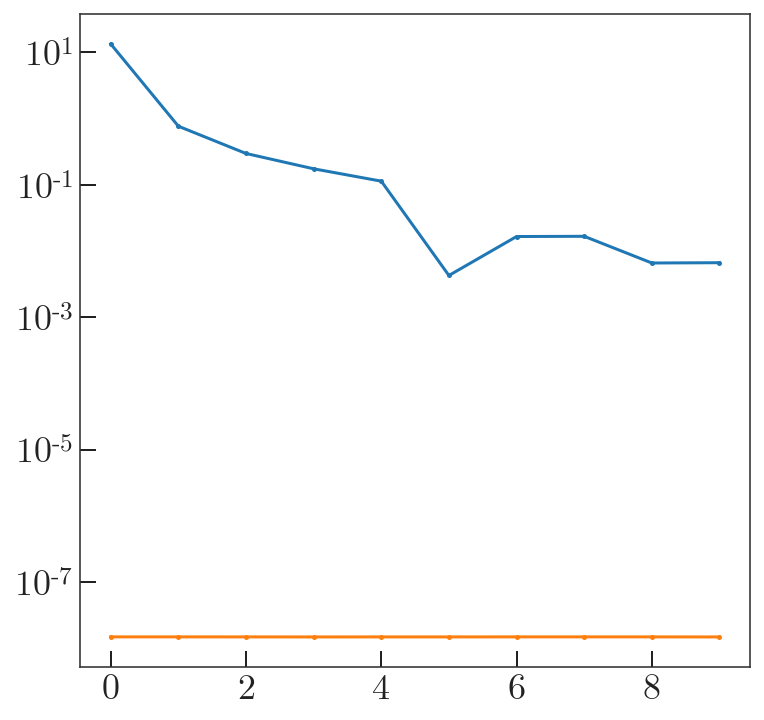

In [4]:
plt.plot(np.abs(S[:, 0, 0]))
plt.plot(np.abs(Serr[:, 0, 0]))
plt.yscale('log')

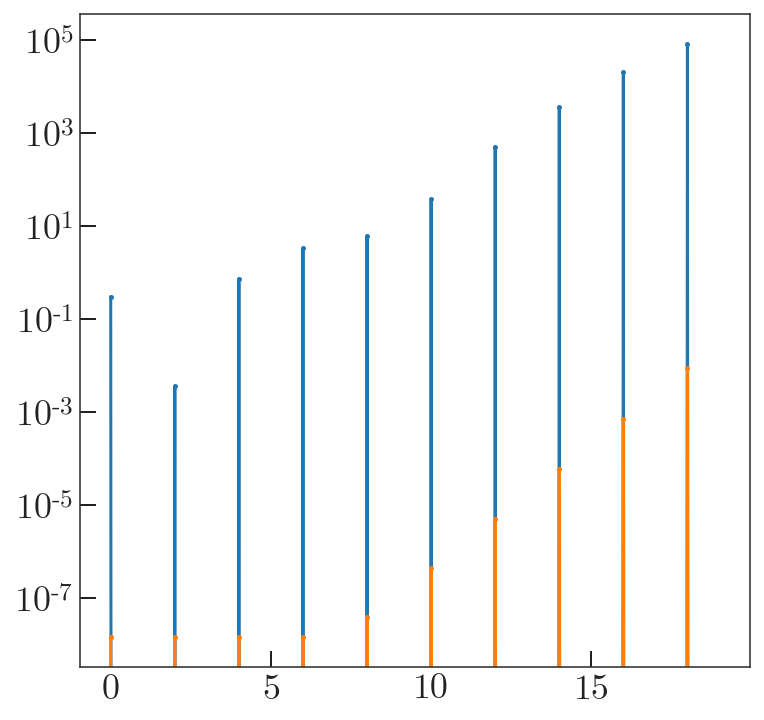

In [5]:
plt.plot(np.abs(S[2, :, 0]))
plt.plot(np.abs(Serr[2, :, 0]))
plt.yscale('log')

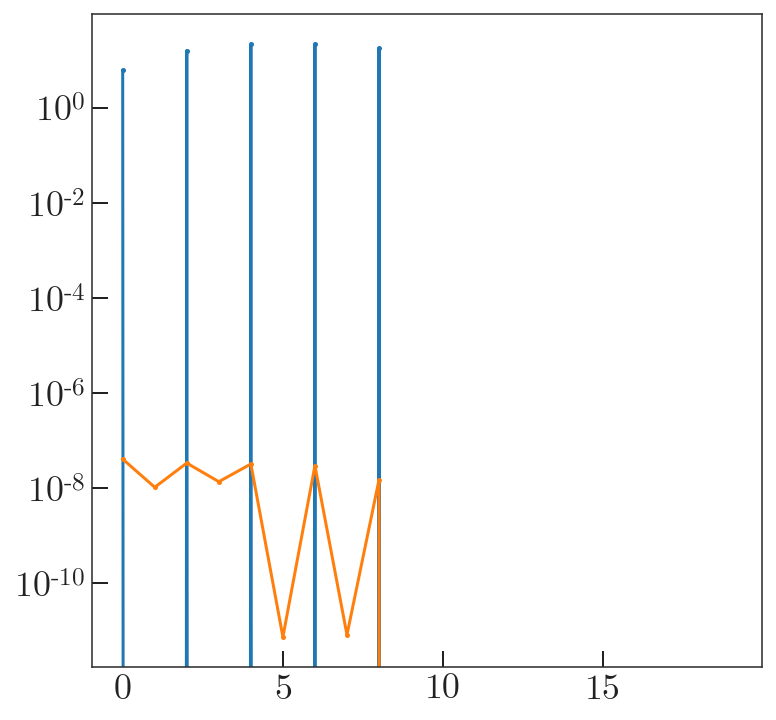

In [6]:
plt.plot(np.abs(S[2, 8, :]))
plt.plot(np.abs(Serr[2, 8, :]))
plt.yscale('log')

---

### Like Banik and Bovy, add bar model to MWPotential2014

Here we just set up the default potential model, before scaling the bar size

In [103]:
pot = gp.CCompositePotential()
pot['disk'] = mw['disk']
pot['halo'] = mw['halo']
pot['bar'] = gp.SCFPotential(m=5e9 / 9, r_s=1., # MAGIC NUMBER: just believe
                             Snlm=S,
                             units=galactic,
                             R=rotation_matrix(-27*u.deg, 'z'))

(0, 300)

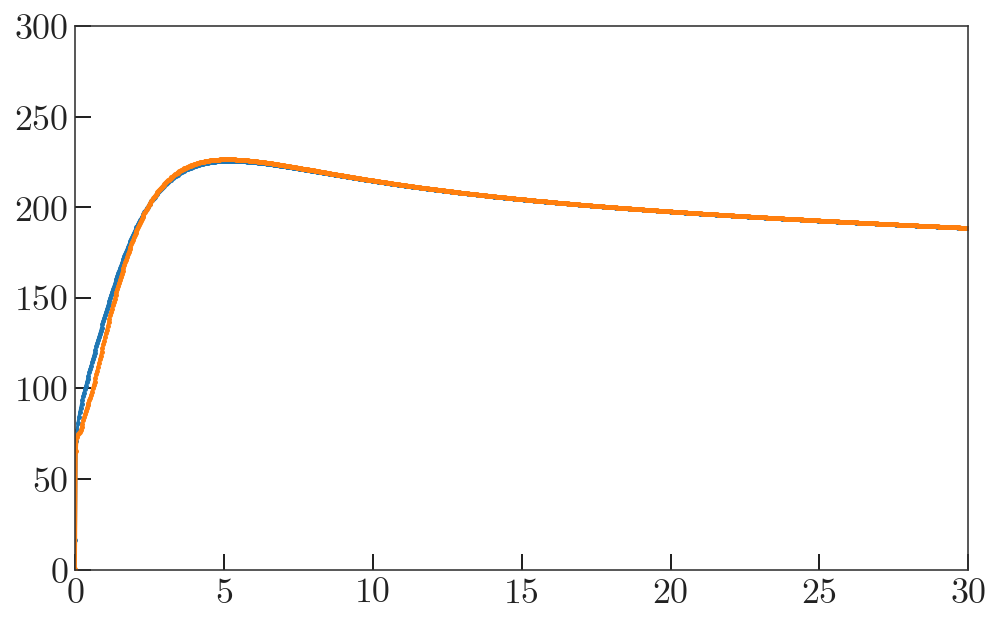

In [104]:
xyz = np.zeros((3, 1024)) + 1e-8
xyz[0] = np.linspace(0, 30, xyz.shape[1])
    
plt.figure(figsize=(8, 5))
plt.plot(xyz[0], mw.circular_velocity(xyz).to_value(u.km/u.s))
plt.plot(xyz[0], pot.circular_velocity(xyz).to_value(u.km/u.s))
plt.xlim(0, 30)
plt.ylim(0, 300)

---

## Visualize surface density

In [105]:
from scipy.integrate import simps

def density_on_grid(density, grid_lim=(-10, 10), ngrid=128):
    if isinstance(ngrid, int):
        ngrids = [ngrid]*3
    else:
        ngrids = ngrid
    grids = [np.linspace(grid_lim[0], grid_lim[1], ngrids[i])
             for i in range(3)]
    xyz = np.vstack(map(np.ravel, np.meshgrid(*grids)))

    val = np.zeros((np.prod(ngrids),))
    val = density(xyz).value
    val[np.isnan(val)] = val[np.isfinite(val)].max()
    
    gridx = xyz[0].reshape(*ngrids)[:,:,0]
    gridy = xyz[1].reshape(*ngrids)[:,:,0]
    
    return gridx, gridy, val

def surface_density(density, grid_lim=(-10, 10), ngrid=128):
    if isinstance(ngrid, int):
        ngrids = [ngrid]*3
    else:
        ngrids = ngrid
    xx, yy, dens3d = density_on_grid(density, ngrid=ngrids, 
                                     grid_lim=grid_lim)
    dens3d = dens3d.reshape(*ngrids)
    
    # Used for integration:
    _x = np.linspace(grid_lim[0], grid_lim[1], ngrids[2])
    return xx, yy, simps(dens3d, x=_x, axis=2)

In [106]:
diskbar = gp.CCompositePotential()
diskbar['disk'] = mw['disk']
diskbar['bar'] = pot['bar']

In [107]:
xg, yg, surf_dens = surface_density(diskbar.density, 
                                    grid_lim=(-15, 15), 
                                    ngrid=[64, 64, 24])

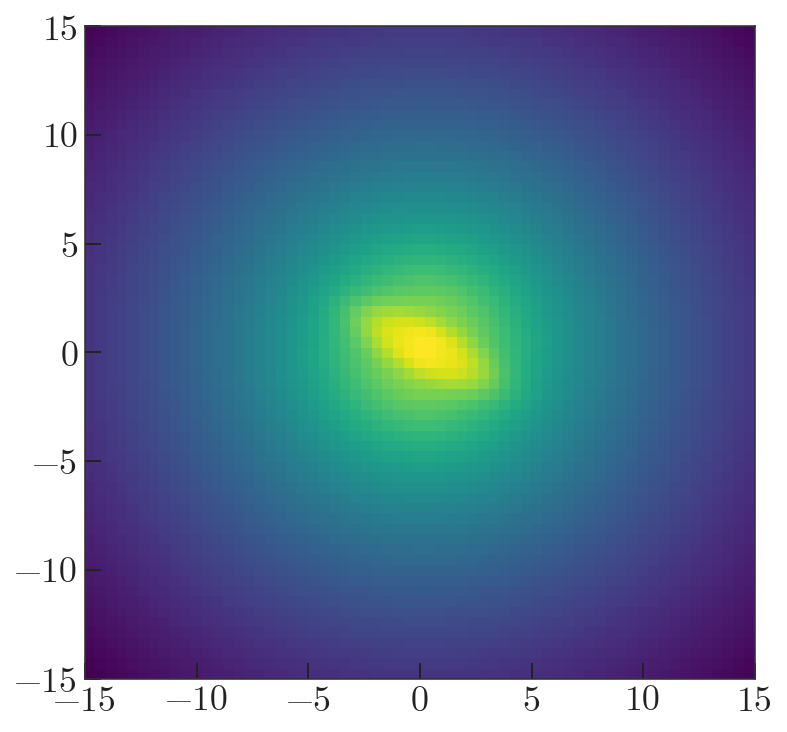

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(xg, yg, surf_dens, 
              norm=mpl.colors.LogNorm())

---

## Figure out bar scaling with pattern speed

In [110]:
disknobar = gp.CCompositePotential()
disknobar['disk'] = mw['disk']
disknobar['bulge'] = mw['bulge']

In [111]:
diskbar1 = gp.CCompositePotential()
diskbar1['disk'] = mw['disk']
diskbar1['bar'] = gp.SCFPotential(m=5e9 / 10., r_s=1., # MAGIC NUMBER: just believe
                                 Snlm=S[:6, :10, :10],
                                 units=galactic)

diskbar2 = gp.CCompositePotential()
diskbar2['disk'] = mw['disk']
diskbar2['bar'] = gp.SCFPotential(m=5e9 / 10., r_s=2, # MAGIC NUMBER: just believe
                                 Snlm=S[:6, :10, :10],
                                 units=galactic)

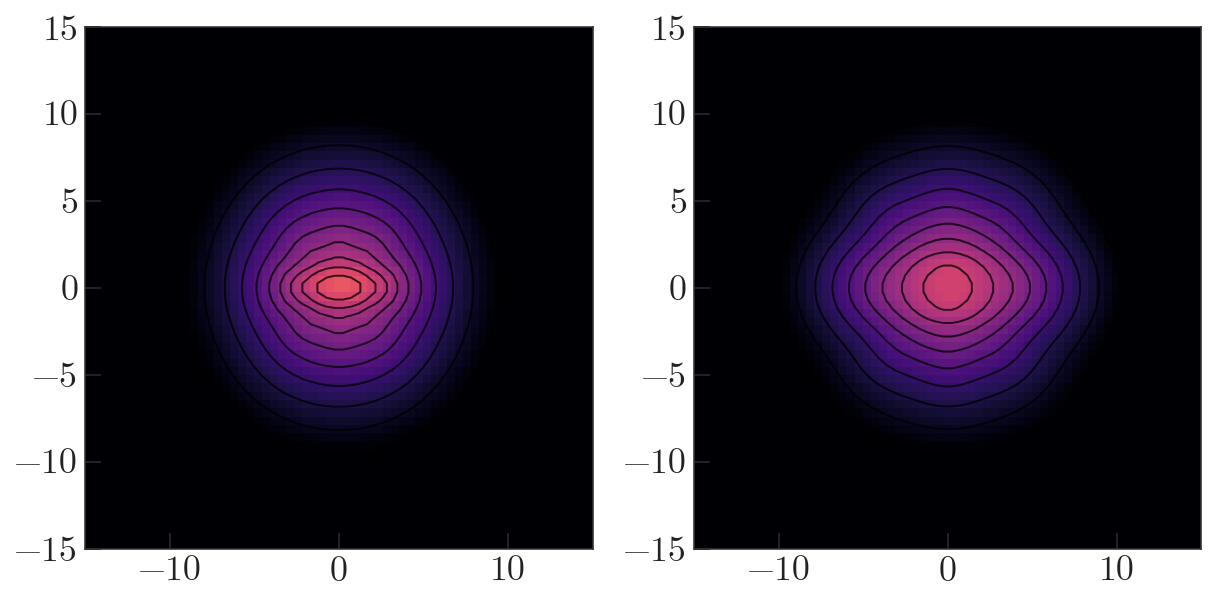

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10,4.8))

for i, pot in enumerate([diskbar1, diskbar2]):
    levels = np.logspace(7., 10, 16)
    norm = mpl.colors.LogNorm(vmin=levels.min(), vmax=levels.max())
    # norm = mpl.colors.Normalize(vmin=levels.min(), vmax=levels.max())
    xx, yy, dens2d = surface_density(pot.density, grid_lim=[-15, 15], ngrid=[64, 64, 24])

    axes[i].pcolormesh(xx, yy, dens2d, cmap='magma', norm=norm)
    axes[i].contour(xx, yy, dens2d, 
                    levels=levels,
                    colors='k', alpha=0.75, linewidths=1)

(0, 300)

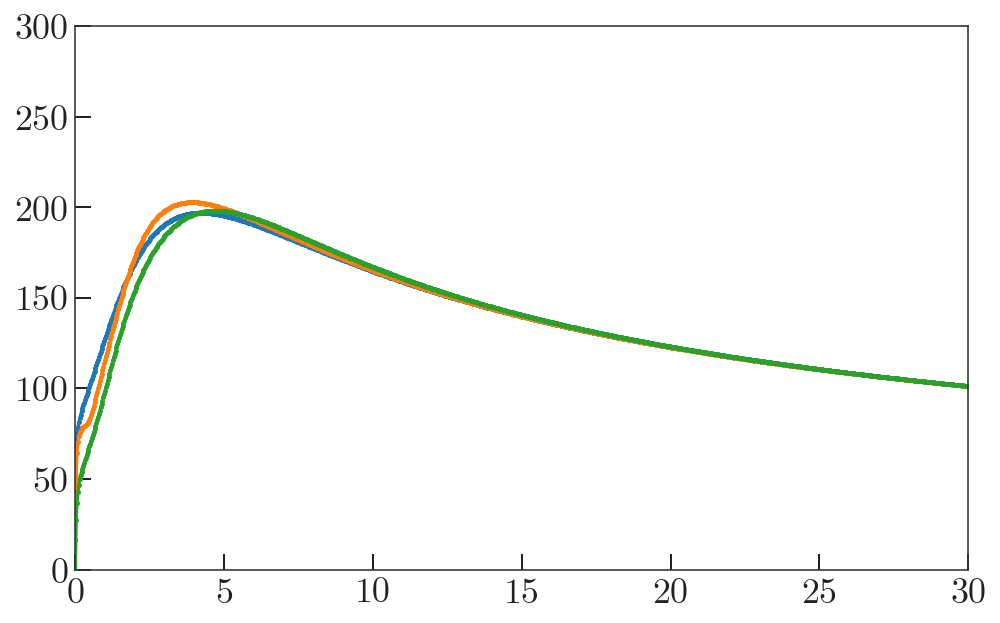

In [114]:
xyz = np.zeros((3, 1024)) + 1e-8
xyz[0] = np.linspace(0, 30, xyz.shape[1])
    
plt.figure(figsize=(8, 5))
plt.plot(xyz[0], disknobar.circular_velocity(xyz).to_value(u.km/u.s))
plt.plot(xyz[0], diskbar1.circular_velocity(xyz).to_value(u.km/u.s))
plt.plot(xyz[0], diskbar2.circular_velocity(xyz).to_value(u.km/u.s))
plt.xlim(0, 30)
plt.ylim(0, 300)

In [115]:
solar_R = [8.1, 0, 0] * u.kpc
print(disknobar.circular_velocity(solar_R),
      diskbar1.circular_velocity(solar_R),
      diskbar2.circular_velocity(solar_R))

[176.70372336] km / s [177.79139046] km / s [179.93868473] km / s


---

## Timing

In [61]:
test = gp.CCompositePotential()
test['disk'] = mw['disk']
test['halo'] = mw['halo']
test['bar'] = gp.SCFPotential(m=5e9 / 10., r_s=1., # MAGIC NUMBER: just believe
                              Snlm=S,
                              units=galactic)

test2 = gp.CCompositePotential()
test2['disk'] = mw['disk']
test2['halo'] = mw['halo']

In [58]:
w0 = gd.PhaseSpacePosition(pos=[8,0,0.]*u.kpc,
                           vel=[0, 220, 100.]*u.km/u.s)
orbit = test.integrate_orbit(w0, dt=0.5, n_steps=10000)

In [62]:
%timeit test.integrate_orbit(w0, dt=0.5, n_steps=1000)

304 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
%timeit test2.integrate_orbit(w0, dt=0.5, n_steps=1000)

1.43 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [65]:
(np.abs(S) > 1e-13).sum()

550